In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import requests
import seaborn as sns

from datetime import datetime
from functools import reduce



## Gathering

In [5]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [6]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### Twitter Image Prediction

In [7]:

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open(os.path.join('image_predictions.tsv'), mode = 'wb') as file:
    file.write(response.content)

df_image= pd.read_csv('image_predictions.tsv', sep='\t')

In [8]:
df_image.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [9]:
df_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [10]:
df_image.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

#### Twitter API
Note: I have requested the twitter developer account but this is not approved. I may use the provided `tweet_json.txt` in this project instead of the twitter api.

In [11]:
df_data = []
with open('tweet-json.txt') as file:
    for line in file:
        try:
            tweet = json.loads(line)
            df_data.append(tweet)
        except:
            continue
df_api = pd.DataFrame(df_data)

In [12]:
# Reduce df_api to the necessary columns
df_twitter = df_api[['id', 'retweet_count', 'favorite_count']]
 
df_twitter.head()

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [13]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


## Accessing


In [14]:
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [15]:
#check for unclear dog names
twitter_archive['name'].unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such',
       'Maya', 'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey',
       'Lilly', 'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella',
       'Grizzwald', 'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey',
       'Gary', 'a', 'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey',
       'Duddles', 'Jack', 'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow',
       'Terrance', 'Aja', 'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict',
       'Venti', 'Goose', 'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian',
       'Walter', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover',
       'Napolean', 'Dawn', 'Boomer', 'Cody', 'Rumble', 'Clifford',
       'quite', 'Dewey', 'Scout', 'Gizmo', 'Cooper', 'Harold', 'Shikha',
       'Jamesy', 'Lili', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Nept

In [16]:
twitter_archive[twitter_archive.in_reply_to_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,671550332464455680,6.715449e+17,4.196984e+09,2015-12-01 04:44:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After 22 minutes of careful deliberation this ...,NaN,NaN,NaN,NaN,1,10,None,None,None,None,None
2149,669684865554620416,6.693544e+17,4.196984e+09,2015-11-26 01:11:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After countless hours of research and hundreds...,NaN,NaN,NaN,NaN,11,10,None,None,None,None,None
2169,669353438988365824,6.678065e+17,4.196984e+09,2015-11-25 03:14:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tessa. She is also very pleased after ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669353438...,10,10,Tessa,None,None,None,None
2189,668967877119254528,6.689207e+17,2.143566e+07,2015-11-24 01:42:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",12/10 good shit Bubka\n@wane15,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None


In [17]:
twitter_archive.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [18]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [19]:
twitter_archive.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [20]:
twitter_archive['retweeted_status_id'].value_counts()

8.874740e+17    1
6.704450e+17    1
6.671828e+17    1
6.661041e+17    1
7.717705e+17    1
               ..
7.950767e+17    1
7.840579e+17    1
8.222448e+17    1
8.224891e+17    1
6.675484e+17    1
Name: retweeted_status_id, Length: 181, dtype: int64

In [21]:
twitter_archive['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [22]:
twitter_archive['timestamp'].value_counts()

2017-08-01 16:23:56 +0000    1
2016-01-13 02:43:46 +0000    1
2016-01-15 02:41:12 +0000    1
2016-01-15 02:08:05 +0000    1
2016-01-15 01:25:33 +0000    1
                            ..
2016-09-11 21:34:30 +0000    1
2016-09-10 23:54:11 +0000    1
2016-09-10 16:03:16 +0000    1
2016-09-09 18:31:54 +0000    1
2015-11-15 22:32:08 +0000    1
Name: timestamp, Length: 2356, dtype: int64

In [23]:
twitter_archive['name'].value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

In [24]:
twitter_archive.rating_numerator.unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88], dtype=int64)

In [25]:
twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
2         9
1         9
75        2
15        2
420       2
0         2
80        1
144       1
17        1
26        1
20        1
121       1
143       1
44        1
60        1
45        1
50        1
99        1
204       1
1776      1
165       1
666       1
27        1
182       1
24        1
960       1
84        1
88        1
Name: rating_numerator, dtype: int64

In [26]:
twitter_archive.rating_denominator.unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2], dtype=int64)

In [27]:
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

In [28]:
twitter_archive.loc[(twitter_archive['doggo']== 'None') & (twitter_archive['floofer']== 'None') & (twitter_archive['pupper']== 'None') & (twitter_archive['puppo']== 'None')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [29]:
twitter_archive.rating_denominator.describe()

count    2356.000000
mean       10.455433
std         6.745237
min         0.000000
25%        10.000000
50%        10.000000
75%        10.000000
max       170.000000
Name: rating_denominator, dtype: float64

In [30]:
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

In [31]:
twitter_archive.rating_numerator.describe()

count    2356.000000
mean       13.126486
std        45.876648
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

In [32]:
twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
2         9
1         9
75        2
15        2
420       2
0         2
80        1
144       1
17        1
26        1
20        1
121       1
143       1
44        1
60        1
45        1
50        1
99        1
204       1
1776      1
165       1
666       1
27        1
182       1
24        1
960       1
84        1
88        1
Name: rating_numerator, dtype: int64

In [33]:
twitter_archive[twitter_archive['rating_denominator'] != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None


In [34]:
twitter_archive[twitter_archive['rating_denominator'] != 10].shape[0]

23

In [35]:
temp_df = twitter_archive[twitter_archive['rating_denominator'] != 10]

pd.set_option('display.max_colwidth', -1)
temp_df[['tweet_id','text','rating_numerator','rating_denominator']]

C:\Users\waad0\AppData\Local\Temp/ipykernel_1296/4249032346.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,tweet_id,text,rating_numerator,rating_denominator
313,835246439529840640,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
342,832088576586297345,@docmisterio account started on 11/15/15,11,15
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
784,775096608509886464,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


### Summary For twitter_archive
#### Quality Issues 
1. Replace None with Nan
2. Data contains 181 retweets (rows where retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp have a number instead of NaN)
3. Erroneous datatype (tweet_id, timestamp). in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id and retweeted_status_user_id are erroneous datatype, but we don't use these.
4. source in HTML format is difficult to read 
5. Incorrect names or missing names in name column, for instance, a, an, the - all are written with lower case letters
6. The denominator columns have invalid values.
7. The numerator columns have invalid values.
8. The dog names format should be consistent. (First letter capital for name column)

#### Tidiness Issues 
1. doggo, floofer, pupper and puppo columns can marge in 1 column.
2. rating_numerator and rating_denominator merge into 1 column.

##### df_image data

In [36]:
df_image

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [37]:
df_image.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [38]:
df_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [39]:
df_image['jpg_url'].value_counts()

https://pbs.twimg.com/media/CZhn-QAWwAASQan.jpg                                            2
https://pbs.twimg.com/media/Cq9guJ5WgAADfpF.jpg                                            2
https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg    2
https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg                                            2
https://pbs.twimg.com/media/CsrjryzWgAAZY00.jpg                                            2
                                                                                          ..
https://pbs.twimg.com/media/CXrmMSpUwAAdeRj.jpg                                            1
https://pbs.twimg.com/media/CXrawAhWkAAWSxC.jpg                                            1
https://pbs.twimg.com/media/CXrIntsUsAEkv0d.jpg                                            1
https://pbs.twimg.com/media/CXqcOHCUQAAugTB.jpg                                            1
https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg                       

In [40]:
df_image['jpg_url'].duplicated().sum()

66

In [41]:
df_image['tweet_id'].duplicated().sum()

0

In [42]:
df_image['p1_dog'].value_counts()

True     1532
False    543 
Name: p1_dog, dtype: int64

In [43]:
df_image['p2_dog'].value_counts()

True     1553
False    522 
Name: p2_dog, dtype: int64

In [44]:
df_image['p3_dog'].value_counts()

True     1499
False    576 
Name: p3_dog, dtype: int64

### Summary For df_image
#### Quality Issues 
1. Lowercase breed names in p1, p2, p3 and '_' is used instead of space.
2. Missing records (2075 rows from df_image instead of 2356 rows from twitter_archive)
3. 66 duplicate jpg_url

#### Tidiness Issues 
1. Refine respective predictions and confidence columns.

##### df_twitter data

In [45]:
df_twitter

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


In [46]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [47]:
df_twitter.isnull().sum()

id                0
retweet_count     0
favorite_count    0
dtype: int64

In [48]:
df_twitter['id'].duplicated().sum()

0

In [49]:
df_twitter.rename(columns = {'id':'tweet_id'}, inplace=True)

C:\Users\waad0\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


## Cleaning

In [50]:
# Create the copies of the dataframes which will be cleaned
df_twitter_archive_clean = twitter_archive.copy()
df_image_clean = df_image.copy()
df_twitter_clean = df_twitter.copy()

#### Merging 3 dataframes

##### Define

both of  df_twitter_clean and df_image_clean joining on tweet_id, so i will merge them on df_twitter_archive_clean.

##### Code

In [51]:
df_twitter_archive_clean = pd.merge(df_twitter_archive_clean, df_twitter_clean, on = ['tweet_id'], how = 'left')

In [52]:
df_twitter_archive_clean = pd.merge(df_twitter_archive_clean, df_image_clean,   on = ['tweet_id'], how = 'left')

##### Test

In [53]:
df_twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,...,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


In [54]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

#### Replace None with Nan

##### Define

Replace the missing value with Nan

##### Code

In [55]:
df_twitter_archive_clean =  df_twitter_archive_clean.replace('None', np.nan)

##### Test

In [56]:
df_twitter_archive_clean.isnull().sum()

tweet_id                      0   
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                     0   
source                        0   
text                          0   
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                 59  
rating_numerator              0   
rating_denominator            0   
name                          745 
doggo                         2259
floofer                       2346
pupper                        2099
puppo                         2326
retweet_count                 2   
favorite_count                2   
jpg_url                       281 
img_num                       281 
p1                            281 
p1_conf                       281 
p1_dog                        281 
p2                            281 
p2_conf                       281 
p2_dog                        281 
p3                            281 
p3_conf             

#### Remove 181 retweets

##### Define

Remove 181 retweets by the columns: rows where retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp have a number instead of NaN)

##### Code

In [57]:

df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean['retweeted_status_id'].isnull()]
df_twitter_archive_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,...,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,...,1.0,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,...,1.0,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,...,1.0,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://t

##### Test

In [58]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        1495 non-null   object 
 13  doggo                       87 no

In [59]:
df_twitter_archive_clean.isnull().sum()

tweet_id                      0   
in_reply_to_status_id         2097
in_reply_to_user_id           2097
timestamp                     0   
source                        0   
text                          0   
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                 58  
rating_numerator              0   
rating_denominator            0   
name                          680 
doggo                         2088
floofer                       2165
pupper                        1941
puppo                         2150
retweet_count                 0   
favorite_count                0   
jpg_url                       181 
img_num                       181 
p1                            181 
p1_conf                       181 
p1_dog                        181 
p2                            181 
p2_conf                       181 
p2_dog                        181 
p3                            181 
p3_conf             

#### Erroneous datatype

##### Define

Change tweet_id, timestamp, rating_numerator, rating_denominator, p1, p2 ,p3, tweet_id datatypes

##### Code

In [60]:
df_twitter_archive_clean['timestamp'] = pd.to_datetime(df_twitter_archive_clean.timestamp)
df_twitter_archive_clean['rating_numerator'] = df_twitter_archive_clean['rating_numerator'].astype(float)
df_twitter_archive_clean['rating_denominator'] = df_twitter_archive_clean['rating_denominator'].astype(float)
df_twitter_archive_clean['p1'] = df_twitter_archive_clean['p1'].astype('category')
df_twitter_archive_clean['p2'] = df_twitter_archive_clean['p1'].astype('category')
df_twitter_archive_clean['p3'] = df_twitter_archive_clean['p1'].astype('category')

##### Test

In [61]:
df_twitter_archive_clean.dtypes

tweet_id                      int64              
in_reply_to_status_id         float64            
in_reply_to_user_id           float64            
timestamp                     datetime64[ns, UTC]
source                        object             
text                          object             
retweeted_status_id           float64            
retweeted_status_user_id      float64            
retweeted_status_timestamp    object             
expanded_urls                 object             
rating_numerator              float64            
rating_denominator            float64            
name                          object             
doggo                         object             
floofer                       object             
pupper                        object             
puppo                         object             
retweet_count                 float64            
favorite_count                float64            
jpg_url                       object             


#### source in HTML format is difficult to read

##### Define

The source is given between the characters ">" and "<", so we need a characters between them

##### Code

In [62]:
df_twitter_archive_clean['source'] = df_twitter_archive_clean['source'].apply(lambda x: re.findall(r'>(.*)<', x)[0])

##### Test

In [63]:
df_twitter_archive_clean.source.value_counts()

Twitter for iPhone     2042
Vine - Make a Scene    91  
Twitter Web Client     31  
TweetDeck              11  
Name: source, dtype: int64

##### Define

Correcting the denominator of the tweet_id whose incorrect(Checking by text)

##### Code

In [64]:
temp_df = df_twitter_archive_clean[df_twitter_archive_clean['rating_denominator'] != 10]

pd.set_option('display.max_colwidth', -1)
temp_df[['tweet_id','text','rating_numerator','rating_denominator']]

C:\Users\waad0\AppData\Local\Temp/ipykernel_1296/2002463970.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,tweet_id,text,rating_numerator,rating_denominator
313,835246439529840640,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960.0,0.0
342,832088576586297345,@docmisterio account started on 11/15/15,11.0,15.0
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84.0,70.0
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24.0,7.0
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165.0,150.0
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9.0,11.0
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204.0,170.0
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4.0,20.0
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50.0,50.0
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99.0,90.0


In [65]:
temp_df.dtypes

tweet_id                      int64              
in_reply_to_status_id         float64            
in_reply_to_user_id           float64            
timestamp                     datetime64[ns, UTC]
source                        object             
text                          object             
retweeted_status_id           float64            
retweeted_status_user_id      float64            
retweeted_status_timestamp    object             
expanded_urls                 object             
rating_numerator              float64            
rating_denominator            float64            
name                          object             
doggo                         object             
floofer                       object             
pupper                        object             
puppo                         object             
retweet_count                 float64            
favorite_count                float64            
jpg_url                       object             


The tweet_id 740373189193256964 ,722974582966214656,716439118184652801,682962037429899265,666287406224695296 have actual denominator as 10 (reference from the text column).

In [66]:
df_twitter_archive_clean.loc[df_twitter_archive_clean.tweet_id == 740373189193256964, ['rating_denominator']] = 10
df_twitter_archive_clean.loc[df_twitter_archive_clean.tweet_id == 722974582966214656, ['rating_denominator']] = 10
df_twitter_archive_clean.loc[df_twitter_archive_clean.tweet_id == 716439118184652801, ['rating_denominator']] = 10
df_twitter_archive_clean.loc[df_twitter_archive_clean.tweet_id == 682962037429899265, ['rating_denominator']] = 10
df_twitter_archive_clean.loc[df_twitter_archive_clean.tweet_id == 666287406224695296, ['rating_denominator']] = 10

##### Test

In [67]:
df_twitter_archive_clean[df_twitter_archive_clean['rating_denominator']==11.0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [68]:
df_twitter_archive_clean[df_twitter_archive_clean['rating_denominator']==20.0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1598,686035780142297088,6.860340e+17,4.196984e+09,2016-01-10 04:04:10+00:00,Twitter for iPhone,"Yes I do realize a rating of 4/20 would've been fitting. However, it would be unjust to give these cooperative pups that low of a rating",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
df_twitter_archive_clean[df_twitter_archive_clean['rating_denominator']==50.0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1274,709198395643068416,NaN,NaN,2016-03-14 02:04:08+00:00,Twitter for iPhone,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",NaN,NaN,NaN,https://twitter.com/dog_rates/status/709198395643068416/photo/1,...,1.0,borzoi,0.490783,True,borzoi,0.083513,True,borzoi,0.083184,True
1351,704054845121142784,NaN,NaN,2016-02-28 21:25:30+00:00,Twitter for iPhone,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704054845121142784/photo/1,...,1.0,Great_Pyrenees,0.667939,True,Great_Pyrenees,0.228764,True,Great_Pyrenees,0.043885,True


In [70]:
df_twitter_archive_clean[df_twitter_archive_clean['rating_denominator']==2.0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


####  The numerator columns have invalid values.

##### Define

Correcting the numerator of the tweet_id, which denominator we corrected above

##### Code

In [71]:
df_twitter_archive_clean.loc[df_twitter_archive_clean.tweet_id == 740373189193256964, ['rating_numerator']] = 14
df_twitter_archive_clean.loc[df_twitter_archive_clean.tweet_id == 722974582966214656, ['rating_numerator']] = 13
df_twitter_archive_clean.loc[df_twitter_archive_clean.tweet_id == 716439118184652801, ['rating_numerator']] = 11
df_twitter_archive_clean.loc[df_twitter_archive_clean.tweet_id == 682962037429899265, ['rating_numerator']] = 10
df_twitter_archive_clean.loc[df_twitter_archive_clean.tweet_id == 666287406224695296, ['rating_numerator']] = 9

##### Test

In [72]:
df_twitter_archive_clean[df_twitter_archive_clean['tweet_id']==740373189193256964].rating_numerator

1068    14.0
Name: rating_numerator, dtype: float64

In [73]:
df_twitter_archive_clean[df_twitter_archive_clean['tweet_id']==722974582966214656].rating_numerator

1165    13.0
Name: rating_numerator, dtype: float64

In [74]:
df_twitter_archive_clean[df_twitter_archive_clean['tweet_id']==716439118184652801].rating_numerator

1202    11.0
Name: rating_numerator, dtype: float64

In [75]:
df_twitter_archive_clean[df_twitter_archive_clean['tweet_id']==682962037429899265].rating_numerator

1662    10.0
Name: rating_numerator, dtype: float64

In [76]:
df_twitter_archive_clean[df_twitter_archive_clean['tweet_id']==666287406224695296].rating_numerator

2335    9.0
Name: rating_numerator, dtype: float64

#### Add rating column, calculating by rating_numerator / rating_denominator

##### Define

Calculating rating by rating_numerator / rating_denominator

##### Code

In [77]:
df_twitter_archive_clean['rating'] = 10 * df_twitter_archive_clean['rating_numerator'] / df_twitter_archive_clean['rating_denominator']

##### Test

In [78]:
df_twitter_archive_clean[['tweet_id', 'rating_numerator', 'rating_denominator', 'rating']]

,tweet_id,rating_numerator,rating_denominator,rating
0,892420643555336193,13.0,10.0,13.0
1,892177421306343426,13.0,10.0,13.0
2,891815181378084864,12.0,10.0,12.0
3,891689557279858688,13.0,10.0,13.0
4,891327558926688256,12.0,10.0,12.0
...,...,...,...,...
2351,666049248165822465,5.0,10.0,5.0
2352,666044226329800704,6.0,10.0,6.0
2353,666033412701032449,9.0,10.0,9.0
2354,666029285002620928,7.0,10.0,7.0


#### Incorrect names or missing names in name column, for instance, a, an, the - all are written with lower case letters

##### Define

Rename the wrong name by NaN

##### Code

In [79]:
df_twitter_archive_clean.name.sort_values(ascending = True).unique()

array(['Abby', 'Ace', 'Acro', 'Adele', 'Aiden', 'Aja', 'Akumi', 'Al',
       'Albert', 'Albus', 'Aldrick', 'Alejandro', 'Alexander',
       'Alexanderson', 'Alf', 'Alfie', 'Alfy', 'Alice', 'Amber',
       'Ambrose', 'Amy', 'Amélie', 'Anakin', 'Andru', 'Andy', 'Angel',
       'Anna', 'Anthony', 'Antony', 'Apollo', 'Aqua', 'Archie', 'Arlen',
       'Arlo', 'Arnie', 'Arnold', 'Arya', 'Ash', 'Asher', 'Ashleigh',
       'Aspen', 'Astrid', 'Atlas', 'Atticus', 'Aubie', 'Augie', 'Autumn',
       'Ava', 'Axel', 'Bailey', 'Baloo', 'Balto', 'Banditt', 'Banjo',
       'Barclay', 'Barney', 'Baron', 'Barry', 'Batdog', 'Bauer', 'Baxter',
       'Bayley', 'BeBe', 'Bear', 'Beau', 'Beckham', 'Beebop', 'Beemo',
       'Bell', 'Bella', 'Belle', 'Ben', 'Benedict', 'Benji', 'Benny',
       'Bentley', 'Berb', 'Berkeley', 'Bernie', 'Bert', 'Bertson',
       'Betty', 'Beya', 'Biden', 'Bilbo', 'Billl', 'Billy', 'Binky',
       'Birf', 'Bisquick', 'Blakely', 'Blanket', 'Blipson', 'Blitz',
       'Bloo', 'Bloop',

In [80]:
df_twitter_archive_clean.name.replace(['a', 'actually', 'all', 'an', 'by', 'getting', 'his',
       'incredibly', 'infuriating', 'just', 'life', 'light', 'mad', 'my',
       'not', 'officially', 'old', 'one', 'quite', 'space', 'such', 'the',
       'this', 'unacceptable', 'very'],np.NaN, inplace =True)

##### Test

In [81]:
df_twitter_archive_clean.name.sort_values(ascending = True).unique()

array(['Abby', 'Ace', 'Acro', 'Adele', 'Aiden', 'Aja', 'Akumi', 'Al',
       'Albert', 'Albus', 'Aldrick', 'Alejandro', 'Alexander',
       'Alexanderson', 'Alf', 'Alfie', 'Alfy', 'Alice', 'Amber',
       'Ambrose', 'Amy', 'Amélie', 'Anakin', 'Andru', 'Andy', 'Angel',
       'Anna', 'Anthony', 'Antony', 'Apollo', 'Aqua', 'Archie', 'Arlen',
       'Arlo', 'Arnie', 'Arnold', 'Arya', 'Ash', 'Asher', 'Ashleigh',
       'Aspen', 'Astrid', 'Atlas', 'Atticus', 'Aubie', 'Augie', 'Autumn',
       'Ava', 'Axel', 'Bailey', 'Baloo', 'Balto', 'Banditt', 'Banjo',
       'Barclay', 'Barney', 'Baron', 'Barry', 'Batdog', 'Bauer', 'Baxter',
       'Bayley', 'BeBe', 'Bear', 'Beau', 'Beckham', 'Beebop', 'Beemo',
       'Bell', 'Bella', 'Belle', 'Ben', 'Benedict', 'Benji', 'Benny',
       'Bentley', 'Berb', 'Berkeley', 'Bernie', 'Bert', 'Bertson',
       'Betty', 'Beya', 'Biden', 'Bilbo', 'Billl', 'Billy', 'Binky',
       'Birf', 'Bisquick', 'Blakely', 'Blanket', 'Blipson', 'Blitz',
       'Bloo', 'Bloop',

In [82]:
#old shape (before cleaning)
twitter_archive.name.shape

(2356,)

In [83]:
#new shape
df_twitter_archive_clean.name.shape

(2175,)

#### doggo, floofer, pupper and puppo columns can marge in 1 column.

##### Define

melt doggo, floofer, pupper and puppo in dog_stage columns, and drop stage columns

##### Code

In [84]:
types = ['doggo', 'floofer', 'pupper', 'puppo']
melt_columns = [x for x in df_twitter_archive_clean.columns.tolist() if x not in types]

# Melt the the columns into values
df_twitter_archive_clean = pd.melt(df_twitter_archive_clean, id_vars = melt_columns, value_vars = types, 
                         var_name = 'stages', value_name = 'dog_stage')

In [85]:
df_twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,rating,stages,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,...,False,orange,0.085851,False,orange,0.076110,False,13.0,doggo,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,...,True,Chihuahua,0.090647,True,Chihuahua,0.068957,True,13.0,doggo,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,...,True,Chihuahua,0.078253,True,Chihuahua,0.031379,True,12.0,doggo,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,...,False,paper_towel,0.168086,True,paper_towel,0.040836,False,13.0,doggo,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",...,True,basset,0.225770,True,basset,0.175219,True,12.0,doggo,NaN


In [86]:
df_twitter_archive_clean = df_twitter_archive_clean.drop('stages', 1)

C:\Users\waad0\AppData\Local\Temp/ipykernel_1296/3609529072.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_twitter_archive_clean = df_twitter_archive_clean.drop('stages', 1)


##### Test

In [87]:
df_twitter_archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'retweet_count', 'favorite_count',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'rating', 'dog_stage'],
      dtype='object')

In [88]:
df_twitter_archive_clean.dog_stage.value_counts()

pupper     234
doggo      87 
puppo      25 
floofer    10 
Name: dog_stage, dtype: int64

##### Define

Refine p1, p2 ,p3, p1_dog, p2_dog, p3_dog into prediction and confidence columns.

##### Code

In [89]:
# https://github.com/vaibhavg12/udacity-data-wrangling/blob/master/wrangle_act.ipynb
# store the true algo with it's level of confidence and if false put NaN as confidence
prediction = []
confidence = []

def get_prediction_confidence(dataframe):
    if dataframe['p1_dog'] == True:
        prediction.append(dataframe['p1'])
        confidence.append(dataframe['p1_conf'])
    elif dataframe['p2_dog'] == True:
        prediction.append(dataframe['p2'])
        confidence.append(dataframe['p2_conf'])
    elif dataframe['p3_dog'] == True:
        prediction.append(dataframe['p3'])
        confidence.append(dataframe['p3_conf'])
    else:
        prediction.append('NaN')
        confidence.append(0)

df_twitter_archive_clean.apply(get_prediction_confidence, axis=1)
df_twitter_archive_clean['prediction'] = prediction
df_twitter_archive_clean['confidence'] = confidence

In [90]:
# drop the not required columns of image prediction information
df_twitter_archive_clean = df_twitter_archive_clean.drop(['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], 1)

C:\Users\waad0\AppData\Local\Temp/ipykernel_1296/603253050.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_twitter_archive_clean = df_twitter_archive_clean.drop(['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], 1)


##### Test

In [91]:
#check if 2 new columns have been added and not required columns have been dropped
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8700 entries, 0 to 8699
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    8700 non-null   int64              
 1   in_reply_to_status_id       312 non-null    float64            
 2   in_reply_to_user_id         312 non-null    float64            
 3   timestamp                   8700 non-null   datetime64[ns, UTC]
 4   source                      8700 non-null   object             
 5   text                        8700 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               8468 non-null   object             
 10  rating_numerator            8700 non-null   float64         

In [92]:
df_twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,rating,dog_stage,prediction,confidence
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,8853.0,39467.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,13.0,NaN,NaN,0.000000
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,6514.0,33819.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,13.0,NaN,Chihuahua,0.323581
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,4328.0,25461.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,12.0,NaN,Chihuahua,0.716012
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,8964.0,42908.0,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,13.0,NaN,paper_towel,0.168086
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,9774.0,41048.0,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,12.0,NaN,basset,0.555712


#### Remove unwanted columns

In [93]:
df_twitter_archive_clean.shape

(8700, 20)

##### Code

In [94]:
df_twitter_archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'retweet_count', 'favorite_count',
       'jpg_url', 'rating', 'dog_stage', 'prediction', 'confidence'],
      dtype='object')

In [95]:
df_twitter_archive_clean = df_twitter_archive_clean.drop(['in_reply_to_status_id','in_reply_to_user_id', 
'retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'],axis=1)

##### Test

In [96]:
df_twitter_archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'retweet_count',
       'favorite_count', 'jpg_url', 'rating', 'dog_stage', 'prediction',
       'confidence'],
      dtype='object')

In [97]:
df_twitter_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,rating,dog_stage,prediction,confidence
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,8853.0,39467.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,13.0,NaN,NaN,0.000000
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,6514.0,33819.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,13.0,NaN,Chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,4328.0,25461.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,12.0,NaN,Chihuahua,0.716012
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,8964.0,42908.0,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,13.0,NaN,paper_towel,0.168086
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,9774.0,41048.0,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,12.0,NaN,basset,0.555712


#### 66 duplicate jpg_url

##### Define

Delete duplicated jpg_url

##### Code

In [98]:
df_twitter_archive_clean = df_twitter_archive_clean.drop_duplicates(subset=['jpg_url'], keep='last')

##### Test

In [99]:
sum(df_twitter_archive_clean['jpg_url'].duplicated())

0

#### Extra: The dog names format should be consistent. (First letter capital for prediction column)

In [100]:
df_twitter_archive_clean['prediction'].str.islower().sum()

785

In [101]:
df_twitter_archive_clean['prediction'] = df_twitter_archive_clean.prediction.str.capitalize()

##### Test

In [102]:
df_twitter_archive_clean['prediction'].str.islower().sum()

0

#### Keeping the data for convenient visualization

In [103]:
#Store the clean DataFrame in a CSV file
df_twitter_archive_clean.to_csv('twitter_archive_master.csv',index=False, encoding = 'utf-8')

In [104]:
df_vis = pd.read_csv('twitter_archive_master.csv')

## Visualizing Data

#### Top 10 Dog Breeds

In [105]:
prediction_value = df_vis.prediction.value_counts()
prediction_value.head()

Nan                   309
Golden_retriever      139
Labrador_retriever    95 
Pembroke              88 
Chihuahua             79 
Name: prediction, dtype: int64

In [106]:
prediction_index = df_vis.prediction.value_counts().index
prediction_index

Index(['Nan', 'Golden_retriever', 'Labrador_retriever', 'Pembroke',
       'Chihuahua', 'Pug', 'Chow', 'Samoyed', 'Toy_poodle', 'Pomeranian',
       ...
       'Ram', 'Hotdog', 'Timber_wolf', 'Hippopotamus', 'Handkerchief',
       'Polecat', 'Cup', 'Rapeseed', 'Sulphur-crested_cockatoo', 'Hay'],
      dtype='object', length=215)

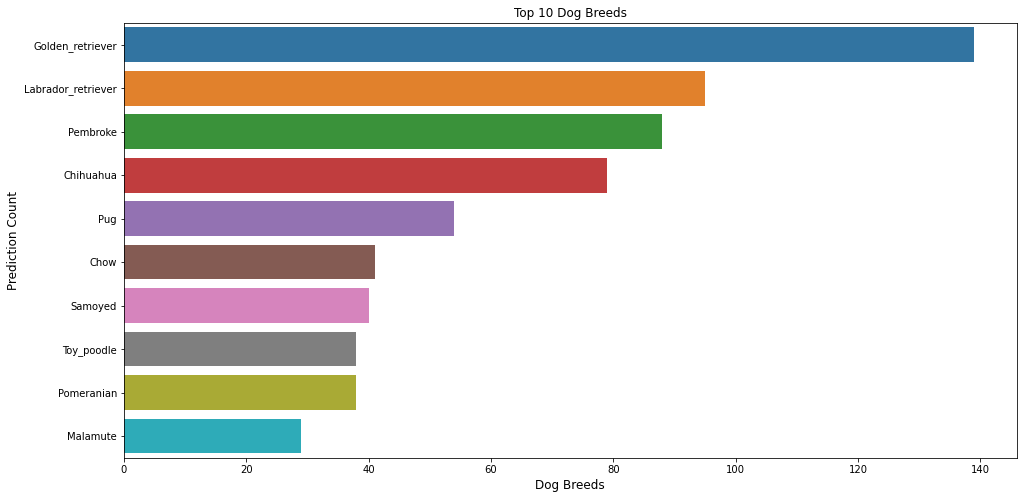

In [107]:
plt.figure(figsize=(16,8))

sns.barplot(x=prediction_value[1:11], y=prediction_index[1:11], data=df_vis);
plt.title('Top 10 Dog Breeds')
plt.xlabel("Dog Breeds",fontsize = 12);
plt.ylabel("Prediction Count",fontsize = 12);

In [114]:
df_vis.source.value_counts()

Twitter for iPhone    1956
Twitter Web Client    28  
TweetDeck             11  
Name: source, dtype: int64